In [1]:
import wandb
import numpy as np
import os
from tqdm import tqdm
import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import argparse
from sklearn import metrics
import torch.nn.functional as F
import mat73

from mydataloader.mydataset import MyDataset
from models.mn.model import get_model as get_mobilenet
from models.dymn.model import get_model as get_dymn
from models.preprocess import AugmentMelSTFT
from helpers.init import worker_init_fn
from helpers.utils import NAME_TO_WIDTH, exp_warmup_linear_down, mixup

In [2]:
import matplotlib.pyplot as plt
import itertools
def _mel_forward(x, mel):
    old_shape = x.size()
    x = x.reshape(-1, old_shape[2])
    x = mel(x)
    x = x.reshape(old_shape[0], old_shape[1], x.shape[1], x.shape[2])
    return x


def _test(model, mel, eval_loader, device):
    model.eval()
    mel.eval()

    targets = []
    outputs = []
    losses = []
    pbar = tqdm(eval_loader)
    pbar.set_description("Validating")
    for batch in pbar:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            x = _mel_forward(x, mel)
            y_hat, _ = model(x)
        targets.append(y.cpu().numpy())
        outputs.append(y_hat.float().cpu().numpy())
        losses.append(F.cross_entropy(y_hat, y).cpu().numpy())

    targets = np.concatenate(targets)
    outputs = np.concatenate(outputs)
    losses = np.stack(losses)

    accuracy = metrics.accuracy_score(targets.argmax(axis=1), outputs.argmax(axis=1))
    map = metrics.average_precision_score(targets.argmax(axis=1), outputs.argmax(axis=1))
    # print(metrics.classification_report(targets.argmax(axis=1), outputs.argmax(axis=1)))

    conf_matrix = metrics.confusion_matrix(targets.argmax(axis=1), outputs.argmax(axis=1))
    # Calculating TP, FP, FN for each class
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP

    # Calculating precision and recall for each class
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    # Calculating F1 score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall)

    return accuracy, losses.mean(), map, precision, recall, f1_scores

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
import argparse
import sys

# Define the argument parser
parser = argparse.ArgumentParser(description="Example script")

# general
parser.add_argument('--experiment_name', type=str, default="MyDataset")
parser.add_argument('--cuda', action='store_true', default=False)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--num_workers', type=int, default=0)
parser.add_argument('--fold', type=int, default=1)
parser.add_argument('--num_class', type=int, default=9)

# training
parser.add_argument('--pretrained', action='store_true', default=False)
parser.add_argument('--model_name', type=str, default="mn10_as")
parser.add_argument('--pretrain_final_temp', type=float, default=1.0)  # for DyMN
parser.add_argument('--model_width', type=float, default=1.0)
parser.add_argument('--head_type', type=str, default="mlp")
parser.add_argument('--se_dims', type=str, default="c")
parser.add_argument('--n_epochs', type=int, default=30)
parser.add_argument('--mixup_alpha', type=float, default=0.3)
parser.add_argument('--no_roll', action='store_true', default=False)
parser.add_argument('--no_wavmix', action='store_true', default=False)
parser.add_argument('--gain_augment', type=int, default=12)
parser.add_argument('--weight_decay', type=int, default=0.0)

# lr schedule
parser.add_argument('--lr', type=float, default=6e-5)
parser.add_argument('--warm_up_len', type=int, default=10)
parser.add_argument('--ramp_down_start', type=int, default=10)
parser.add_argument('--ramp_down_len', type=int, default=65)
parser.add_argument('--last_lr_value', type=float, default=0.01)

# preprocessing
parser.add_argument('--resample_rate', type=int, default=32000)
parser.add_argument('--window_size', type=int, default=800)
parser.add_argument('--hop_size', type=int, default=320)
parser.add_argument('--n_fft', type=int, default=1024)
parser.add_argument('--n_mels', type=int, default=128)
parser.add_argument('--freqm', type=int, default=0)
parser.add_argument('--timem', type=int, default=0)
parser.add_argument('--fmin', type=int, default=0)
parser.add_argument('--fmax', type=int, default=None)
parser.add_argument('--fmin_aug_range', type=int, default=10)
parser.add_argument('--fmax_aug_range', type=int, default=2000)

# select dataset
parser.add_argument('--start_sub', type=int, default=None)
parser.add_argument('--end_sub', type=int, default=None)

# Simulate command line arguments
sys.argv = ['--cuda', '--model_name=mn10_as', '--batch_size=32', '--lr=0.0003', '--start_sub=27', '--num_class=3']

# Parse the arguments
args = parser.parse_args()

print(args)

Namespace(experiment_name='MyDataset', cuda=False, batch_size=32, num_workers=0, fold=1, num_class=3, pretrained=False, model_name='mn10_as', pretrain_final_temp=1.0, model_width=1.0, head_type='mlp', se_dims='c', n_epochs=30, mixup_alpha=0.3, no_roll=False, no_wavmix=False, gain_augment=12, weight_decay=0.0, lr=0.0003, warm_up_len=10, ramp_down_start=10, ramp_down_len=65, last_lr_value=0.01, resample_rate=32000, window_size=800, hop_size=320, n_fft=1024, n_mels=128, freqm=0, timem=0, fmin=0, fmax=None, fmin_aug_range=10, fmax_aug_range=2000, start_sub=27, end_sub=None)


In [4]:
# model to preprocess waveform into mel spectrograms
device = torch.device('cuda') if args.cuda and torch.cuda.is_available() else torch.device('cpu')
mel = AugmentMelSTFT(n_mels=args.n_mels,
                     sr=args.resample_rate,
                     win_length=args.window_size,
                     hopsize=args.hop_size,
                     n_fft=args.n_fft,
                     freqm=args.freqm,
                     timem=args.timem,
                     fmin=args.fmin,
                     fmax=args.fmax,
                     fmin_aug_range=args.fmin_aug_range,
                     fmax_aug_range=args.fmax_aug_range
                     )
mel.to(device)

AugmentMelSTFT(
  (freqm): Identity()
  (timem): Identity()
)

In [43]:
# load prediction model
model_name = args.model_name
pretrained_name = model_name if args.pretrained else None
width = NAME_TO_WIDTH(model_name) if model_name and args.pretrained else args.model_width
if model_name.startswith("dymn"):
    model = get_dymn(width_mult=width, pretrained_name=pretrained_name,
                     pretrain_final_temp=args.pretrain_final_temp,
                     num_classes=args.num_class)
else:
    model = get_mobilenet(width_mult=width, pretrained_name=pretrained_name,
                          head_type=args.head_type, se_dims=args.se_dims,
                          num_classes=args.num_class)

MN(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

/home/ychen239/anaconda3/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [44]:
# Load the saved state dictionary
model.load_state_dict(torch.load("./saved_models/single_cross_1.pt"))
model.to(device)

MN(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [7]:
# load data
directory = '../processedData/v2'
file_names = [f for f in os.listdir(directory) if f.endswith('.mat')]
all_data, all_labels = [], []
file_names = sorted(file_names)
file_names = sorted(file_names)[:-3]
for file_name in file_names:
    mat = mat73.loadmat(os.path.join(directory, file_name))
    data = mat['audio_data'] 
    label = mat['label']
    all_data.append(np.transpose(data))
    all_labels.append(label)
all_data = np.array(all_data, dtype=object)
all_labels = np.array(all_labels, dtype=object)

# dataloader
start_sub, end_sub = args.start_sub, args.end_sub
if start_sub and end_sub:
    print("test set:", file_names[start_sub:end_sub])
    traindataset = MyDataset(datasource = np.concatenate((all_data[0:start_sub], all_data[end_sub:]), axis=0),
                            labels = np.concatenate((all_labels[0:start_sub], all_labels[end_sub:]), axis=0),
                            window_size=1.5, 
                            step_size=0.5, 
                            transform=None,
                            classes_num = args.num_class)

    # evaluation loader
    evaldataset = MyDataset(datasource = all_data[start_sub:end_sub],
                            labels = all_labels[start_sub:end_sub],
                            window_size=1.5, 
                            step_size=0.5, 
                            transform=None,
                            classes_num = args.num_class)
elif start_sub:
    print("test set:", file_names[start_sub:])
    traindataset = MyDataset(datasource = all_data[:start_sub],
                            labels = all_labels[:start_sub],
                            window_size=1.5, 
                            step_size=0.5, 
                            transform=None,
                            classes_num = args.num_class)

    # evaluation loader
    evaldataset = MyDataset(datasource = all_data[start_sub:],
                                labels = all_labels[start_sub:],
                                window_size=1.5, 
                                step_size=0.5, 
                                transform=None,
                                classes_num = args.num_class)
else:
    print("test set:", file_names[:end_sub])
    traindataset = MyDataset(datasource = all_data[end_sub:],
                            labels = all_labels[end_sub:],
                            window_size=1.5, 
                            step_size=0.5, 
                            transform=None,
                            classes_num = args.num_class)

    # evaluation loader
    evaldataset= MyDataset(datasource = all_data[:end_sub], 
                            labels = all_labels[:end_sub],
                            window_size=1.5, 
                            step_size=0.5, 
                            transform=None,
                            classes_num = args.num_class)

test set: ['014_1_multi.mat', '014_2_multi.mat', '014_3_multi.mat', '015_1_multi.mat', '015_2_multi.mat', '015_3_multi.mat', '016_1_multi.mat', '016_2_multi.mat', '016_3_multi.mat']


In [38]:
train_indices = []
for i, (_, label) in enumerate(traindataset):
    # print(x[0].shape)
    # print(x[1].shape)
    # print(x[2].shape)
    if np.sum(label) != 0:
        train_indices += [i]

dl = DataLoader(dataset=Subset(traindataset, train_indices),
                worker_init_fn=worker_init_fn,
                num_workers=args.num_workers,
                batch_size=args.batch_size,
                shuffle=True)

eval_dl = DataLoader(dataset= evaldataset,
                     worker_init_fn=worker_init_fn,
                     num_workers=args.num_workers,
                     batch_size=args.batch_size)

In [10]:
eval_indices = []
for i, (_, label) in enumerate(evaldataset):
    if np.sum(label) != 0:
        eval_indices += [i]


eval_dl = DataLoader(dataset= Subset(evaldataset, eval_indices),
                     worker_init_fn=worker_init_fn,
                     num_workers=args.num_workers,
                     batch_size=args.batch_size)

In [45]:
model.eval()
mel.eval()

targets = []
outputs = []
losses = []
train_features = []
def get_features(module, input, output):
    train_features.append(output.cpu().numpy())
handle = model.classifier[4].register_forward_hook(get_features)

pbar = tqdm(dl)
pbar.set_description("Validating")
for batch in pbar:
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        x = _mel_forward(x, mel)
        y_hat, feature = model(x)
    targets.append(y.cpu().numpy())
    outputs.append(y_hat.float().cpu().numpy())
    losses.append(F.cross_entropy(y_hat, y).cpu().numpy())

targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
losses = np.stack(losses)
train_features = np.concatenate(train_features)
handle.remove()

Validating:  54%|██████████████████████████████████▌                             | 182/337 [00:13<00:11, 14.00it/s]


KeyboardInterrupt: 

In [10]:
train_features.shape

(10928, 1280)

In [47]:
model.eval()
mel.eval()

test_targets = []
test_outputs = []
test_features = []
def get_features(module, input, output):
    test_features.append(output.cpu().numpy())
handle = model.classifier[4].register_forward_hook(get_features)
pbar = tqdm(eval_dl)
pbar.set_description("Validating")
for batch in pbar:
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        x = _mel_forward(x, mel)
        y_hat, feature = model(x)
    test_targets.append(y.cpu().numpy())
    test_outputs.append(y_hat.float().cpu().numpy())

test_targets = np.concatenate(test_targets)
test_outputs = np.concatenate(test_outputs)
test_features = np.concatenate(test_features)
handle.remove()

Validating: 100%|████████████████████████████████████████████████████████████████| 405/405 [00:27<00:00, 14.96it/s]


In [48]:
test_features.shape

(12951, 1280)

In [31]:
w = model.classifier[-1].weight.cpu().detach().numpy()
b = model.classifier[-1].bias.cpu().detach().numpy()
print(w.shape, b.shape)

(3, 1280) (3,)


In [49]:
from numpy.linalg import norm, pinv
from scipy.special import logsumexp, softmax
from sklearn import metrics
from sklearn.covariance import EmpiricalCovariance
from sklearn.metrics import pairwise_distances_argmin_min

# logit_id_train = train_features @ w.T + b
logit_id_val = test_features @ w.T + b

print('computing softmax...')
# softmax_id_train = softmax(logit_id_train, axis=-1)
softmax_id_val = softmax(logit_id_val, axis=-1)

u = -np.matmul(pinv(w), b)

computing softmax...


In [19]:
def generalized_entropy(softmax_id_val, gamma, M):
    probs =  softmax_id_val 
    probs_sorted = np.sort(probs, axis=1)[:,-M:]
    scores = np.sum(probs_sorted**gamma * (1 - probs_sorted)**(gamma), axis=1)

    return -scores 

result = []
score_id = generalized_entropy(softmax_id_val, 0.2, 2)

In [20]:
final_gt = []
for i in range(len(score_id)):
    if sum(test_targets[i]) == 0:
        final_gt.append(0)
    else: final_gt.append(1)

In [21]:
from ood_metrics import calc_metrics

calc_metrics(np.array(score_id),np.array(final_gt))

{'fpr_at_95_tpr': 0.9400984995991295,
 'detection_error': 0.32576892359783177,
 'auroc': 0.6996719213175693,
 'aupr_in': 0.67770218178542,
 'aupr_out': 0.7616219510150016}

In [43]:
import cupy as cp

def logsumexp_gpu(arr, axis=None):
    # Find the maximum value in the array to avoid numerical issues
    arr_max = cp.max(arr, axis=axis, keepdims=True)
    
    # Stable computation of log sum exp
    if axis is None:
        return arr_max + cp.log(cp.sum(cp.exp(arr - arr_max)))
    else:
        return arr_max + cp.log(cp.sum(cp.exp(arr - arr_max), axis=axis))
    
    
result = []
DIM = 320
print(f'{DIM=}')

print('computing principal space...')
train_features_gpu = cp.asarray(train_features)
test_features_gpu = cp.asarray(test_features)
logit_id_train_gpu = cp.asarray(logit_id_train)
logit_id_val_gpu = cp.asarray(logit_id_val)
u_gpu = cp.asarray(u)

# Center the features
centered_features = train_features_gpu - u_gpu

# Compute covariance matrix
cov_matrix = cp.cov(centered_features, rowvar=False)

# Compute eigenvalues and eigenvectors
eig_vals, eigen_vectors = cp.linalg.eigh(cov_matrix)

# Compute NS on the GPU
NS_gpu = cp.ascontiguousarray((eigen_vectors.T[cp.argsort(eig_vals * -1)[DIM:]]).T)
NS = cp.asnumpy(NS_gpu)

print('computing alpha...')
vlogit_id_train = norm(np.matmul(train_features - u, NS), axis=-1)
alpha = logit_id_train.max(axis=-1).mean() / vlogit_id_train.mean()
print(f'{alpha=:.4f}')

vlogit_id_val = norm(np.matmul(test_features - u, NS), axis=-1) * 0.5
energy_id_val = logsumexp(logit_id_val, axis=-1)
score_id = -vlogit_id_val + energy_id_val

DIM=320
computing principal space...
computing alpha...
alpha=0.4943


In [44]:
from ood_metrics import calc_metrics

calc_metrics(np.array(score_id),np.array(final_gt))

{'fpr_at_95_tpr': 0.8755010880769671,
 'detection_error': 0.3183041147331251,
 'auroc': 0.7876946067316926,
 'aupr_in': 0.7717627430504435,
 'aupr_out': 0.8309157746026656}

In [30]:
def generalized_entropy(softmax_id_val, gamma, M):
    probs =  softmax_id_val 
    probs_sorted = np.sort(probs, axis=1)[:,-M:]
    scores = np.sum(probs_sorted**gamma * (1 - probs_sorted)**(gamma), axis=1)

    return -scores 

In [31]:
GEN_score_id = generalized_entropy(softmax_id_val, 0.1, 100)
score_id =  vlogit_id_val*GEN_score_id

In [32]:
calc_metrics(np.array(score_id),np.array(final_gt))

{'fpr_at_95_tpr': 0.89405566372695,
 'detection_error': 0.3248225613437191,
 'auroc': 0.7712409234188145,
 'aupr_in': 0.7600905980080606,
 'aupr_out': 0.8154605892416311}

In [50]:
entropy = -np.sum(softmax_id_val * np.log2(softmax_id_val),axis=1)
labelss = test_targets.argmax(axis=1)
for i in range(len(test_targets)):
    if sum(test_targets[i]) == 0:
        labelss[i] = 3

In [34]:
labelss.shape

(4125,)

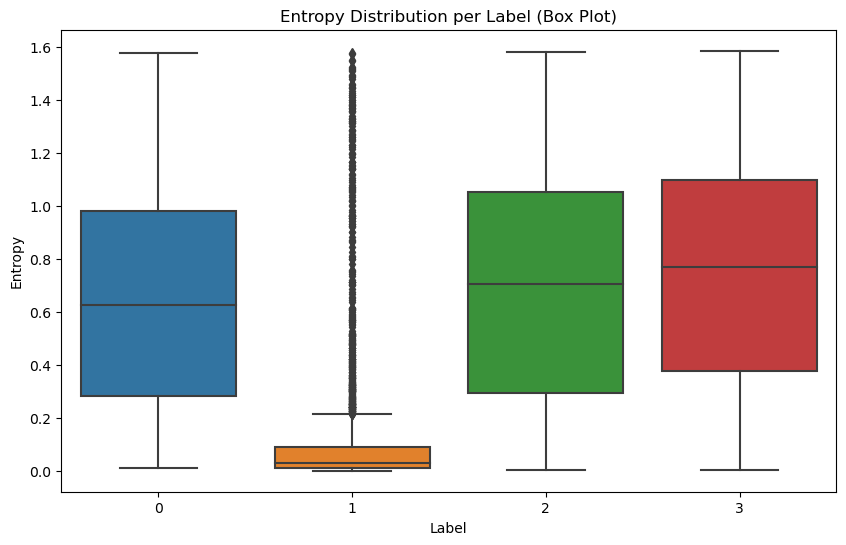

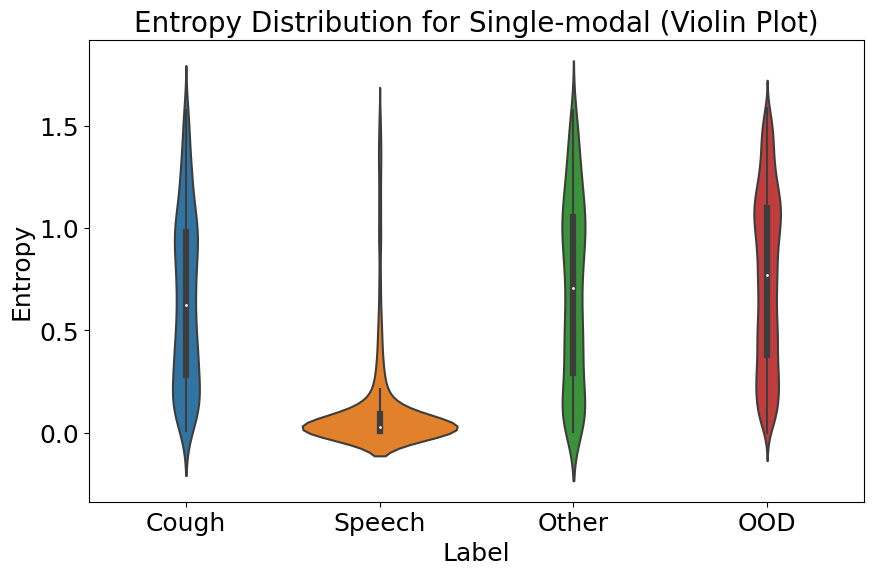

In [53]:
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    'Entropy': entropy,
    'Label': labelss
})

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Entropy', data=data)
plt.title('Entropy Distribution per Label (Box Plot)')
plt.show()

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Label', y='Entropy', data=data, fontsize = 16)
plt.xticks(np.arange(4), ['Cough', 'Speech','Other', 'OOD'])
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18) 
plt.ylabel('Entropy',fontsize=18) 
plt.xlabel('Label',fontsize=18) 
plt.title('Entropy Distribution for Single-modal (Violin Plot)', fontsize=20)
plt.show()